In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints
import numpy as np
import logging
import math

In [16]:

class SGD(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the SGD method. 
    SGD stands for Stochastic Gradient Descent.
    """

    def __init__(self, x0, sigma0=None, boundaries=None):
        super(SGD, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Best solution found
        self._xbest = pints.vector(x0)
        self._fbest = float('inf')

        # Python logger
        self._logger = logging.getLogger(__name__)
        self._population_size = 20
        
    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True
      
        # New sample with all but one parameter fixed
        # Issue, our fbest and xbest are meaning less because we are not exploring on all 
        # params at the same time.. (isn't a huge issue however)
        self._xs = [[0,0]]
        self._zs = np.array([np.random.normal(1, 1) 
                             for i in range(self._population_size)])
        for i in range(self._n_parameters):
            # Moddify only for one parameter
            temp = np.full((self._population_size, self._n_parameters), self._weights)
            temp[:,i] *= self._zs
            self._xs = np.concatenate((self._xs, temp))
        self._xs = self._xs[1:]
        
        
        if self._manual_boundaries:
            # Manual boundaries? Then pass only xs that are within bounds
            self._user_ids = np.nonzero(
                [self._boundaries.check(x) for x in self._xs])
            self._user_xs = self._xs[self._user_ids]
            if len(self._user_xs) == 0:     # pragma: no cover
                self._logger.warning(
                    'All points requested by SGD are outside the boundaries.')
        else:
            self._user_xs = self._xs

        # Set as read-only and return
        self._user_xs.setflags(write=False)
        return self._user_xs

    def fbest(self):
        """ See :meth:`Optimiser.fbest()`. """
        return self._fbest

    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert(not self._running)
        
        #TODO, make change possible
        self._step_size = 0.00000001
        
        self._manual_boundaries = False
        self._boundary_transform = None
        if isinstance(self._boundaries, pints.RectangularBoundaries):
            self._boundary_transform = pints.TriangleWaveTransform(
                self._boundaries)
        elif self._boundaries is not None:
            self._manual_boundaries = True

        self._weights = np.array(self._x0)
        
        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Constant Step Stochastic Gradient Descent (SGD)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        print_info = False
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False

        
        if self._manual_boundaries and len(fx) < self._population_size:
            user_fx = fx
            fx = np.ones((self._population_size, )) * float('inf')
            fx[self._user_ids] = user_fx
        
        
        order = np.argsort(fx)
        gradient = self._approx_grad(fx)
        
        
        
        if print_info:
            print("Inputs", self._user_xs)
            print("Scores", fx)
            print("Grad", gradient)
        
        self._weights -= self._step_size * gradient
        
        if fx[order[0]] < self._fbest:
            self._fbest = fx[order[0]]
            self._xbest = self._xs[order[0]]
    
    # This should approximate the gradient. 
    # We are essentially approximating the partial derivative for each param
    def _approx_grad(self, scores):
        n = self._n_parameters
        p = self._population_size
        result = np.zeros(n)
        for i in range(n):
            for j in range(p):
                for k in range(j+1 ,p):
                    result[i] += (scores[j + i*p] - scores[k + i*p]) / (self._user_xs[j + i*p][i] - self._user_xs[k + i*p][i])
        return result / (p * (p-1)/2)
    

            
    def xbest(self):
        """ See :meth:`Optimiser.xbest()`. """
        return self._xbest 

In [17]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values, gradients = model.simulateS1(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
my_problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(my_problem)

score_sgd = pints.MeanSquaredError(my_problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

# Choose an initial position
x0 = [0.03, 700]

[1.44390743e-02 4.99383617e+02]


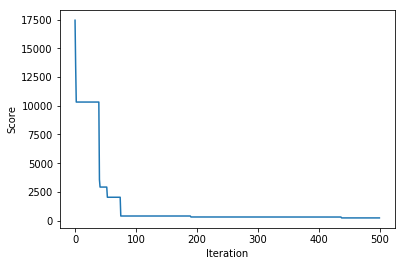

In [42]:
# Create an SGD object
sgd = SGD(x0, boundaries=boundaries)

# Run optimisation
best_fx = []
for i in range(500):
    # Get the next points to evaluate
    xs = sgd.ask()
    # Evaluate the scores
    fxs = [score_sgd(x) for x in xs]
    # Pass the result back to XNES
    sgd.tell(fxs)
    # Store the best score
    best_fx.append(sgd.fbest())

print(sgd.xbest())
# Show how the score converges
axes = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Score')
#axes.set_ylim([-5,1000])
plt.plot(best_fx)
plt.show()



[1.49861045e-02 5.00194255e+02]


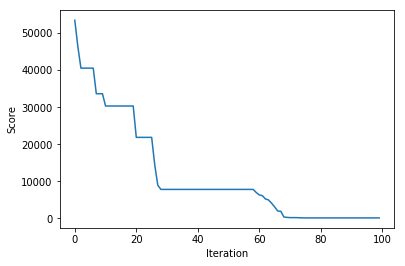

In [43]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
best_fx = []
for i in range(100):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores
    fxs = [score_sgd(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)
    # Store the best score
    best_fx.append(xnes.fbest())

# Show how the score converges
print(xnes.xbest())
plt.figure()
axes = plt.gca()
#axes.set_ylim([-5,1000])
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.plot(best_fx)
plt.show()